In [6]:
import pandas as pd
import altair as alt
import numpy as np
import scipy.io
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [7]:
base_dir = '/home/mrama/GRASP_test/GRASP/output_test/'
n_models = 1000

file_in_MCA = ''.join([base_dir, 'MCA_MEP_test.mat']) 
file_in_mets = ''.join([base_dir, 'MEP_test_metsActive.dat']) 
file_in_rxns = ''.join([base_dir, 'MEP_test_rxnsActive.dat']) 
file_in_enzs = ''.join([base_dir, 'MEP_test_enzNames.dat']) 

In [8]:
def get_name_list(file_in):
    
    name_list = []
    with open(file_in, 'r') as f_in:
        line = f_in.readline()
        line = f_in.readline()
        while line:          
            name_list.append(line[2:].strip())
            line = f_in.readline()

    return name_list

rxn_names = get_name_list(file_in_rxns)
enz_names = get_name_list(file_in_enzs)
met_names = get_name_list(file_in_mets)

In [22]:
def get_df_median(mat, key_name, id_col, col_names, row_names, n_models):
    
    try:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item())
        df.columns = col_names
    except ValueError:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item()[0])
        df.columns = col_names

    df[id_col] = np.tile(row_names, n_models)
    df_median = df.groupby(id_col).median()
    
    return df_median


def get_df_iqr(mat, key_name, id_col, col_names, row_names, n_models):
    
    try:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item())
        df.columns = col_names
    except ValueError:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item()[0])
        df.columns = col_names

    df[id_col] = np.tile(row_names, n_models)
   
    df_q2 = df.groupby(id_col).quantile(0.25)
    df_q4 = df.groupby(id_col).quantile(0.75)
    
    df_iqr = df_q4.subtract(df_q2)    

    return df_iqr



mat = scipy.io.loadmat(file_in_MCA, squeeze_me=True)

key_name = 'vControl'
id_col = 'rxns'
col_names = rxn_names
row_names = rxn_names
Cv_df_median = get_df_median(mat, key_name, id_col, col_names, row_names, n_models)
Cv_df_iqr = get_df_iqr(mat, key_name, id_col, col_names, row_names, n_models)

key_name = 'xControl'
id_col = 'mets'
col_names = rxn_names
row_names = met_names
Cx_df_median = get_df_median(mat, key_name, id_col, col_names, row_names, n_models)
Cx_df_iqr = get_df_iqr(mat, key_name, id_col, col_names, row_names, n_models)
    


In [19]:
def get_heatmaps(C_df_in, id_col):
    
    C_df = C_df_in
    
    C_df[id_col] = C_df.index
    C_df = C_df.melt(id_vars=[id_col], var_name='variable')
    
    Cx_in = alt.Chart(C_df).mark_rect().encode(
        x='variable:N',
        y=id_col,
        color=alt.Color('value:Q', scale=alt.Scale(scheme='redblue', domain=[1,-1])),
        tooltip='value:Q'
    ).properties(
        width=300,
        height=250
    )

    return Cx_in 

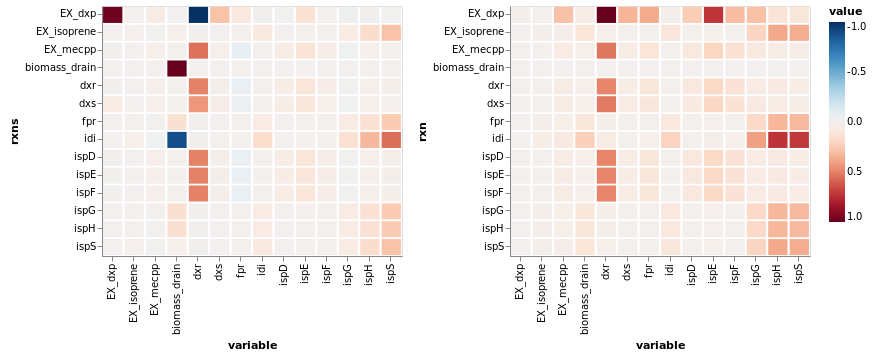

In [20]:
alt.hconcat(get_heatmaps(Cv_df_median, 'rxns'),
            get_heatmaps(Cv_df_iqr, 'rxn'))

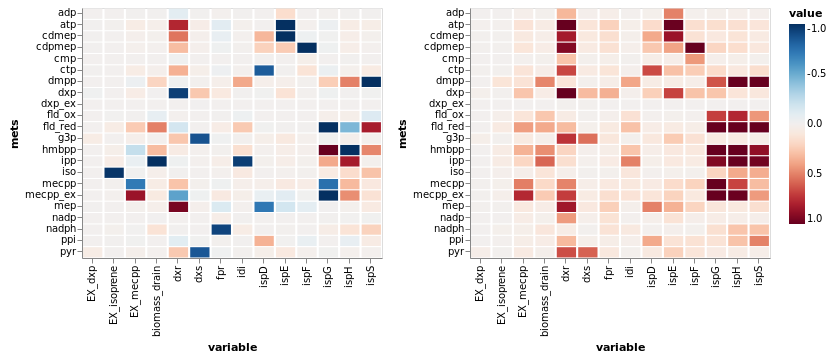

In [21]:
alt.hconcat(get_heatmaps(Cx_df_median, 'mets'),
            get_heatmaps(Cx_df_iqr, 'mets'))